In [3]:
%%html 
<style>
    #btable, th, tr, td {border:none!important}
</style>

# SI-649 Scientific visualization final
### *Uniqname: ningzr*

In [2]:
%pip install future
%pip install matplotlib
%pip install scipy
%pip install seaborn
%pip install numpy
%pip install altair
%pip install panel
from __future__ import print_function, division, generators
import sys
print("Running Python {0}.{1}".format(  
    sys.version_info[:2][0],sys.version_info[:2][1]))
if sys.version_info[:2] > (3, 0):
    print("Adding xrange for backwards compatibility".format(
            sys.version_info[:2][0],sys.version_info[:2][1]))
    from past.builtins import xrange
#from __future__ import print_function,division,generators
%pylab inline
from scipy.stats import pearsonr
import pandas as pd
import datetime as dt
from scipy.stats import kendalltau
import seaborn as sns
from random import randrange
sns.set(style="darkgrid")  # Optionally change plotstyle ('whitegrid', 'ticks','darkgrid')
import altair as alt
# Import panel and vega datasets
import panel as pn
pn.extension() 
import numpy as np

Running Python 3.11
Adding xrange for backwards compatibility
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
monsoon = pd.read_csv('https://raw.githubusercontent.com/Koi4595/SI-649/main/Monsoon_data.csv', parse_dates=['Date'])
monsoon.index = monsoon.Date
# monsoon = monsoon.drop('Date', axis=1)

olou = pd.read_csv('https://raw.githubusercontent.com/Koi4595/SI-649/main/Olou_counts.csv',parse_dates=['Date'])
olou.index = olou.Date
# olou = olou.drop('Date', axis=1) 
olou['Date'] = pd.to_datetime(olou['Date'])

## Visualization 1 Time series

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output  
import pandas as pd

drought_years = [1965, 1966, 1968, 1972, 1974, 1979, 1982, 1986, 1987, 2002, 2004, 2009]
flood_years = [1964, 1970, 1971, 1973, 1975, 1978, 1983, 1988, 1990, 1994, 2007, 2008]


out = widgets.Output()

event_selector = widgets.Dropdown(
    options=['All', 'Drought', 'Flood'],
    value='All',  # 初始状态设置为“All”
    description='Event Type:',
)

def plot_timeseries(event_type):
    with out:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
        
        if event_type == 'Drought':
            monsoon_selected_years = monsoon[monsoon['Date'].dt.year.isin(drought_years)]
            olou_selected_years = olou[olou['Date'].dt.year.isin(drought_years)]
        elif event_type == 'Flood':
            monsoon_selected_years = monsoon[monsoon['Date'].dt.year.isin(flood_years)]
            olou_selected_years = olou[olou['Date'].dt.year.isin(flood_years)]
        else:
            monsoon_selected_years = monsoon
            olou_selected_years = olou
        

        ax1.step(monsoon_selected_years['Date'], monsoon_selected_years['Precip'], where='mid', color='blue')
        ax1.set_title('Monthly Precipitation for Selected Years')
        ax1.set_ylabel('Precipitation (mm)')
        ax1.grid(True)

        ax2.plot(olou_selected_years['Date'], olou_selected_years['Counts']/1000, 'r.', ms=3.0)
        ax2.set_ylabel('Olou NM Counts for Selected Years (cnt./min. x 10^3)')
        ax2.set_xlabel('Date')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

def on_selector_change(change):
    plot_timeseries(change.new)

event_selector.observe(on_selector_change, names='value')

out = widgets.Output()
display(event_selector, out)

plot_timeseries(event_selector.value)

Dropdown(description='Event Type:', options=('All', 'Drought', 'Flood'), value='All')

Output()

In [7]:
def return_stderr(data):
    """Calculate uncertainty of a np array as Standard Error of the Mean"""
    return np.nanstd(data)/np.sqrt(np.count_nonzero(data) - 1)

climo = {}       # Produce a dic of monthly climatology using list comprehension
climo['means'] = [np.mean(monsoon.Precip[monsoon.index.month == (mnth+1)])
                  for mnth in xrange(12)]
climo['error'] = [return_stderr(monsoon.Precip[monsoon.index.month == (mnth+1)].values) 
                    for mnth in xrange(12)]

In [8]:
# Calculate monthly 𝛿 precip. (anomaly with respect to seasonal climatology)
delta = []
for date in monsoon.Precip.index:
    delta.append(monsoon.Precip[date] - climo['means'][date.month-1])
dseries = pd.Series(delta, index=monsoon.index)

In [9]:
# Create a dictionary of June July August September data
def lookup_index(yr):
    return ((monsoon.index.year == yr) & (monsoon.index.month >= 6) 
           &(monsoon.index.month <= 9))
jjas = {}
jjas['means']=[np.mean(dseries[lookup_index(yr)]) for yr in xrange(1964,2012,1)]
jjas['SEM']=[return_stderr(dseries[lookup_index(yr)])for yr in xrange(1964,2012,1)]
jjas['sum']=[np.sum(dseries[lookup_index(yr)]) for yr in xrange(1964,2012,1)]

## Visualization 2 JJAS condition

In [10]:
import altair as alt
import pandas as pd

drought_years = [1965, 1966, 1968, 1972, 1974, 1979, 1982, 1986, 1987, 2002, 2004, 2009]
flood_years = [1964, 1970, 1971, 1973, 1975, 1978, 1983, 1988, 1990, 1994, 2007, 2008]

color_scale = alt.Scale(
    domain=['Drought', 'Flood', 'Normal'],
    range=['darkred', 'lightblue', 'orange']
)

jjas_df = pd.DataFrame({
    'Year': range(1964, 2012),
    'Means': jjas['means'],
    'SEM': jjas['SEM'],
    'Sum': jjas['sum']
})
jjas_df['Condition'] = jjas_df['Year'].apply(lambda x: 'Drought' if x in drought_years else 'Flood' if x in flood_years else 'Normal')

# Now, create the error bar chart and points with the color condition based on the 'Condition' column
error_bars = alt.Chart(jjas_df).mark_errorbar(extent='ci').encode(
    x=alt.X('Year:O', axis=alt.Axis(values=list(range(1960, 2011, 10)))),
    y=alt.Y('Means:Q', scale=alt.Scale(zero=False)),
    yError='SEM:Q',
   color=alt.Color('Condition:N', scale=color_scale)
).properties(
    width=400,
    height=400,
    title='Mean JJAS precipitation anomaly'
)

points = alt.Chart(jjas_df).mark_point(filled=True).encode(
    x='Year:O',
    y='Means:Q',
    color=alt.Color('Condition', legend=alt.Legend(title='Condition'))  # Add a legend
)

# Combine the error bars with the points
error_chart = (error_bars + points).interactive()

# Create the histogram chart, independent of the conditions
histogram = alt.Chart(jjas_df).transform_density(
    density='Means',
    as_=['Means', 'Density']
).mark_area().encode(
    x="Means:Q",
    y='Density:Q',
    tooltip=['Means:Q', 'Density:Q']
).properties(
    width=400,
    height=400,
    title='Distribution of JJAS anomalies'
)

# Horizontally concatenate the error chart with the histogram
chart2 = alt.hconcat(error_chart, histogram).resolve_legend(color='independent')

# Display the final concatenated chart
chart2

alt.HConcatChart(...)

## Visualization 3 Drought/Flood sample

In [11]:
def make_cframe(c_years):
    '''
    Function to take a list of composite years (c_years)
    and create a numpy array (c_years, months) for analysis.
    Also returns back a month-wise set of means, and SEM values.
    '''
    c_group = np.zeros((12,12),dtype=float) 
    for n, yr in enumerate(c_years):
        tmp = olou.index.year == yr
        for i in xrange(len(olou.Counts[tmp])):
            c_group[n,i] = olou.Counts[tmp][i]
    aaa = np.where(c_group == 0)
    c_group[aaa] = np.nan
    c_means = []
    c_errors = []
    for i in xrange(12):
        c_means.append(np.nanmean(c_group[:,i]))   # per month, all years
        c_errors.append(return_stderr(c_group[:,i]))
    return c_group,c_means,c_errors

In [12]:
drought_years = [1965, 1966, 1968, 1972, 1974,1979,
                 1982, 1986, 1987, 2002, 2004, 2009]

flood_years = [1964, 1970, 1971, 1973, 1975, 1978, 
               1983, 1988, 1990, 1994, 2007, 2008]

d_group,d_means,d_errors = make_cframe(drought_years)
f_group,f_means,f_errors = make_cframe(flood_years)

d_means = np.array(d_means) * 0.001
f_means = np.array(f_means) * 0.001
d_errors = np.array(d_errors) * 0.001    # Make the values smaller for plotting
f_errors = np.array(f_errors) * 0.001

C:\Users\HP\AppData\Local\Temp\ipykernel_22144\2318271557.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_group[n,i] = olou.Counts[tmp][i]


C:\Users\HP\AppData\Local\Temp\ipykernel_22144\461619174.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


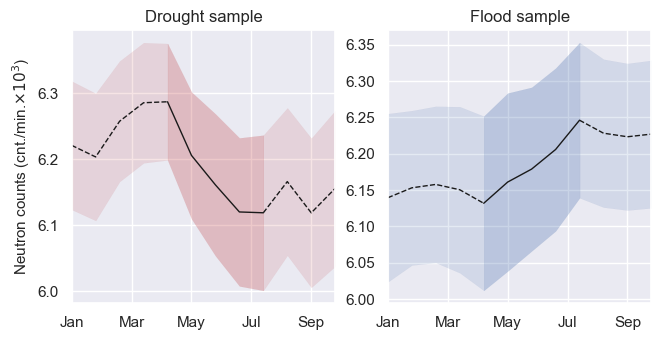

interactive(children=(Dropdown(description='Type:', options=('Drought', 'Flood'), value='Drought'), Checkbox(v…

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
def simBA15plot(ax, dataset, derr, col_key):
    """
    Set the plot and properties of the figure sub-pannels.
    """
    lthick=1.0
    ax.plot(mrange[0:5], dataset[0:5], 'k--',lw=lthick)  # Jan to May
    ax.plot(mrange[4:9], dataset[4:9], 'k-',lw=lthick)   # May to Sep
    ax.plot(mrange[8:], dataset[8:], 'k--',lw=lthick)    # Sep to Dec
    ax.fill_between(mrange[0:5],(dataset[0:5] - derr[0:5]),
                    (dataset[0:5] + derr[0:5]), color=col_key, linewidth=0.1,alpha=0.15)
    ax.fill_between(mrange[4:9], (dataset[4:9] - derr[4:9]), (dataset[4:9] + derr[4:9]),
                    color=col_key, linewidth=0.1, alpha=0.3)
    ax.fill_between(mrange[8:],(dataset[8:] - derr[8:]), (dataset[8:] + derr[8:]),
                    color=col_key, linewidth=0.1, alpha=0.15)
    ax.set_xticklabels(xlabs)
    ax.set_xlim(0,11)
    return

mrange = arange(0,12)
xlabs =['Jan','Mar','May','Jul','Sep','Nov']

figBA15 = plt.figure()
figBA15.set_size_inches(7.48,3.54)
ax1 = figBA15.add_subplot(121)          
ax2 = figBA15.add_subplot(122) 
simBA15plot(ax=ax1, dataset=d_means, derr=d_errors, col_key='r')
simBA15plot(ax=ax2, dataset=f_means, derr=f_errors, col_key='b')
ax1.set_ylabel(r"Neutron counts (cnt./min.$\times10^{3}$)", fontsize=11)
ax1.set_title('Drought sample')
ax2.set_title('Flood sample')
plt.show(figBA15)

def update_chart(data_set='Drought', show_error=True):
    dataset = d_means if data_set == 'Drought' else f_means
    derr = d_errors if data_set == 'Drought' else f_errors
    col_key = 'r' if data_set == 'Drought' else 'b'
    
    fig, ax = plt.subplots(figsize=(7.48, 3.54))
    ax.plot(mrange, dataset, 'k-', lw=1.0)
    if show_error:
        ax.fill_between(mrange, dataset - derr, dataset + derr, color=col_key, alpha=0.3)
    ax.set_xticks(np.arange(len(xlabs)))
    ax.set_ylabel(r"Neutron counts (cnt./min.$\times10^{3}$)", fontsize=11)
    ax.set_xticklabels(xlabs)
    ax.set_title(f'{data_set} sample')
    plt.show()

# 交互式控件
data_set_dropdown = widgets.Dropdown(options=['Drought', 'Flood'], description='Type:')
show_error_checkbox = widgets.Checkbox(value=True, description='Show Error')

interactive_plot = interactive(update_chart, data_set=data_set_dropdown, show_error=show_error_checkbox)
interactive_plot

## Visualization 4 Drought/Flood sample distribution

A Pearson's r test, gives linear regressions and two-tailed p-values of:
Drought sample: r-value = -0.949, p-value = 0.014
Flood sample: r-value = 0.001, p-value = 0.001


c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


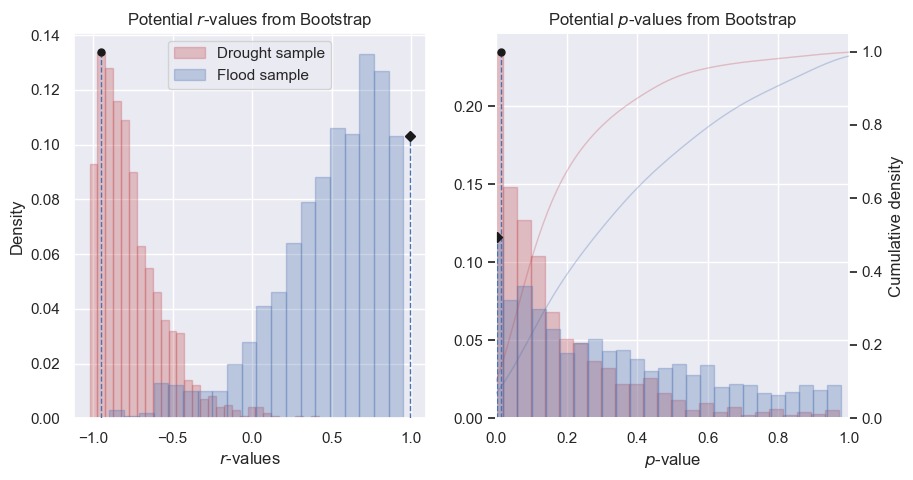

interactive(children=(Dropdown(description='Sample:', options=('Both', 'Drought', 'Flood'), value='Both'), Int…

In [14]:
from ipywidgets import interactive, IntSlider, FloatSlider, Dropdown
rval_d,pval_d = pearsonr(xrange(5),d_means[4:9])
rval_f,pval_f = pearsonr(xrange(5),f_means[4:9])
print("A Pearson's r test, gives linear regressions and two-tailed p-values of:")
print("Drought sample: r-value = {0:4.3f}, p-value = {1:4.3f}".format(rval_d, pval_d))     
print("Flood sample: r-value = {1:4.3f}, p-value = {1:4.3f}".format(rval_f, pval_f))
# Some more functions...
def bootstrap_r(mean_list, error_list, iterations=1000):
    """
    Bootstrap info. Error and means are set up to accept data from make_cframe()
    which is why the offsets within the arrays have been hard-coded to the months
    of key interest (monsoon period).
    Guess a possible min and max (poss_min/max) values based on observed mean and 
    calculate SEM values. Assume an equal chance of any value in that range occurring.
    For a specified number of realization (controlled by iterations) calculate the 
    r-value and p-value, of the linear correlation. Save them to a MC array.
    """
    bs_rvals = []
    bs_pvals = []
    for itr in xrange(iterations):
        poss_vals = []   # List for possible values of CR flux
        for n in range(5):
            #nb. Below factor preserves sig. figs. in change float > ints
            poss_min = int((mean_list[4 + n] - error_list[4 + n]) * 100000) 
            poss_max = int((mean_list[4 + n] + error_list[4 + n]) * 100000)
            poss_vals.append(randrange(poss_min,poss_max)/100)
            #print(4+n,poss_min/100,poss_max/100,poss_vals[-1])
        rv, pv = pearsonr([0,1,2,3,4],poss_vals) # rval, pval
        bs_rvals.append(rv)
        bs_pvals.append(pv)
    bs_rvals = np.array(bs_rvals)
    bs_pvals = np.array(bs_pvals)
    return bs_rvals, bs_pvals


def freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From http://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))
    

    
def iqr(data):
    """Return Inter Quartile Range"""
    q75, q25 = np.percentile(data, [75 ,25])
    return q75 - q25

def add_hist(data, col_key, axobj, mkstyle='o', 
             obsval=None, mylabel=None, bin_num=None):
    """
    Custom Plotting function for histograms.
    data - np.array of values, e.g. generated by bootstrap_r()
    col_key - code for setting color
    axobj - axis object to add the plot to
    mylabel - a label for the plotting legend
    obsval - the observed r-value for comparison (e.g. rval_d)
    mkstyle - matplotlib marker style (default set to circle 'o')
    """
    if not bin_num:
        bin_num = freedman_diaconis_bins(data) #if no bins set, use FD spacing
    hist, bin_edges = np.histogram(data, bins=bin_num, density=False)
    norm_hist = hist / sum(hist) # Normalize the data to show density
    axobj.bar(bin_edges[0:-1], norm_hist, width = bin_edges[1] - bin_edges[0], 
            color = col_key, edgecolor = col_key, alpha = 0.3, label=mylabel)
    mylabel = None
    if obsval:
        lookup = np.where(abs(obsval - bin_edges[0:-1]) == 
                          min(abs(obsval - bin_edges[0:-1])))
        axobj.vlines(obsval,0,norm_hist[lookup], linestyles='dashed',
               lw=1.0, zorder=6, label=mylabel)
        axobj.plot(obsval, norm_hist[lookup], color='k', marker=mkstyle, 
                   ms=5., zorder=7, label=mylabel)
    if bin_num is not None:
     bin_num = int(bin_num) 

rbs1, pbs1 = bootstrap_r(mean_list = d_means, error_list = d_errors)
rbs2, pbs2 = bootstrap_r(mean_list = f_means, error_list = f_errors)

#---- Create plot object 1 (possible r and p-vals)
possible_r = plt.figure()
possible_r.set_size_inches(10,5)
ax1 = possible_r.add_subplot(121)
ax2 = possible_r.add_subplot(122)

# --- Pannel 1 (r-values)
add_hist(data=rbs1, col_key='r', axobj=ax1, obsval=rval_d, 
         mylabel="Drought sample", mkstyle='o')
add_hist(data=rbs2, col_key='b', axobj=ax1, obsval=rval_f, 
         mylabel="Flood sample", mkstyle='D')
ax1.legend(loc=9, prop={'size':11}, numpoints=1, markerscale=5.,
            frameon=True, fancybox=True)

#ax1.set_xlim(-1,1)
ax1.set_ylabel('Density')
ax1.set_xlabel('$r$-values')
ax1.set_title('Potential $r$-values from Bootstrap')

# --- Pannel 2 (p-values)
add_hist(data=pbs1, col_key='r', axobj=ax2, bin_num=25,
        obsval=pval_d, mkstyle='o')
add_hist(data=pbs2, col_key='b', axobj=ax2, bin_num=25,
        obsval=pval_f, mkstyle='D')

ax3 = ax2.twinx()
sns.kdeplot(pbs1, cumulative=True, color='r', ax=ax3, 
            lw=1, alpha=0.3, zorder = 10 )
sns.kdeplot(pbs2, cumulative=True, color='b', ax=ax3, 
            lw=1, alpha=0.3, zorder = 11)
ax3.grid(False)
ax3.set_ylabel("Cumulative density")

ax2.set_title(r'Potential $p$-values from Bootstrap')
ax2.set_xlim(0,1)
ax2.set_xlabel(r'$p$-value')
plt.show(possible_r)
possible_r.savefig('possible_rvals.pdf',dpi=300)

def update_plots(sample_type, bin_num_r, bin_num_p):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # 第一个图表 - r-values
    if sample_type == 'Drought' or sample_type == 'Both':
        add_hist(data=rbs1, col_key='r', axobj=ax1, obsval=rval_d, 
                 mylabel="Drought sample", mkstyle='o', bin_num=bin_num_r)
    if sample_type == 'Flood' or sample_type == 'Both':
        add_hist(data=rbs2, col_key='b', axobj=ax1, obsval=rval_f, 
                 mylabel="Flood sample", mkstyle='D', bin_num=bin_num_r)
    ax1.legend(loc='upper right')
    ax1.set_ylabel('Density')
    ax1.set_xlabel('$r$-values')
    ax1.set_title('Potential $r$-values from Bootstrap')

    # 第二个图表 - p-values
    if sample_type == 'Drought' or sample_type == 'Both':
        add_hist(data=pbs1, col_key='r', axobj=ax2, obsval=pval_d, mkstyle='o', bin_num=bin_num_p)
    if sample_type == 'Flood' or sample_type == 'Both':
        add_hist(data=pbs2, col_key='b', axobj=ax2, obsval=pval_f, mkstyle='D', bin_num=bin_num_p)

    ax3 = ax2.twinx()
    if sample_type == 'Drought' or sample_type == 'Both':
        sns.kdeplot(pbs1, cumulative=True, color='r', ax=ax3, 
                    lw=1, alpha=0.3, zorder=10)
    if sample_type == 'Flood' or sample_type == 'Both':
        sns.kdeplot(pbs2, cumulative=True, color='b', ax=ax3, 
                    lw=1, alpha=0.3, zorder=11)
    ax3.grid(False)
    ax3.set_ylabel("Cumulative density")
    ax2.set_xlabel(r'$p$-value')
    ax2.set_title(r'Potential $p$-values from Bootstrap')
    
    plt.show()

sample_dropdown = Dropdown(options=['Both', 'Drought', 'Flood'], value='Both', description='Sample:')
bin_slider_r = IntSlider(value=30, min=10, max=100, step=1, description='r-value bins:')
bin_slider_p = IntSlider(value=25, min=10, max=100, step=1, description='p-value bins:')

interactive_plot = interactive(update_plots, sample_type=sample_dropdown, bin_num_r=bin_slider_r, bin_num_p=bin_slider_p)
interactive_plot